# 과적합 해결

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [62]:
# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [63]:
# 데이터 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [64]:
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)    # (배치 크기, h, w) -> (배치 크기, 특성)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [65]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [66]:
print('배치 정규화 적용 안함')
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print('\n배치 정규화 적용')
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)

배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2658, Accuracy: 0.9168
Epoch 2 | Val Loss: 0.1959, Accuracy: 0.9392
Epoch 3 | Val Loss: 0.1351, Accuracy: 0.9575
Epoch 4 | Val Loss: 0.1338, Accuracy: 0.9564
Epoch 5 | Val Loss: 0.1324, Accuracy: 0.9588

배치 정규화 적용
Epoch 1 | Val Loss: 0.1186, Accuracy: 0.9659
Epoch 2 | Val Loss: 0.0892, Accuracy: 0.9727
Epoch 3 | Val Loss: 0.0915, Accuracy: 0.9702
Epoch 4 | Val Loss: 0.0806, Accuracy: 0.9756
Epoch 5 | Val Loss: 0.0754, Accuracy: 0.9761


In [67]:
for batch_size in [16, 32, 128]:
    print(f"batch size: {batch_size}")
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch size: 16
Epoch 1 | Val Loss: 0.1191, Accuracy: 0.9644
Epoch 2 | Val Loss: 0.0933, Accuracy: 0.9719
Epoch 3 | Val Loss: 0.0788, Accuracy: 0.9768
Epoch 4 | Val Loss: 0.0838, Accuracy: 0.9749
Epoch 5 | Val Loss: 0.0719, Accuracy: 0.9791
batch size: 32
Epoch 1 | Val Loss: 0.1202, Accuracy: 0.9630
Epoch 2 | Val Loss: 0.0875, Accuracy: 0.9728
Epoch 3 | Val Loss: 0.0813, Accuracy: 0.9757
Epoch 4 | Val Loss: 0.0710, Accuracy: 0.9770
Epoch 5 | Val Loss: 0.0744, Accuracy: 0.9761
batch size: 128
Epoch 1 | Val Loss: 0.1448, Accuracy: 0.9593
Epoch 2 | Val Loss: 0.1063, Accuracy: 0.9692
Epoch 3 | Val Loss: 0.0960, Accuracy: 0.9698
Epoch 4 | Val Loss: 0.0896, Accuracy: 0.9725
Epoch 5 | Val Loss: 0.0870, Accuracy: 0.9746


### 드롭아웃 적용

In [68]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [69]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

for rate in [0.2, 0.5, 0.8]:
    print(f'Dropout Rate: {rate}')
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2586, Accuracy: 0.9214
Epoch 2 | Val Loss: 0.1830, Accuracy: 0.9443
Epoch 3 | Val Loss: 0.1582, Accuracy: 0.9499
Epoch 4 | Val Loss: 0.1433, Accuracy: 0.9553
Epoch 5 | Val Loss: 0.1380, Accuracy: 0.9605
Dropout Rate: 0.5
Epoch 1 | Val Loss: 0.3649, Accuracy: 0.8955
Epoch 2 | Val Loss: 0.3027, Accuracy: 0.9113
Epoch 3 | Val Loss: 0.2648, Accuracy: 0.9213
Epoch 4 | Val Loss: 0.2554, Accuracy: 0.9240
Epoch 5 | Val Loss: 0.2468, Accuracy: 0.9267
Dropout Rate: 0.8
Epoch 1 | Val Loss: 1.7162, Accuracy: 0.4833
Epoch 2 | Val Loss: 1.6999, Accuracy: 0.5087
Epoch 3 | Val Loss: 1.6075, Accuracy: 0.5774
Epoch 4 | Val Loss: 1.6440, Accuracy: 0.5663
Epoch 5 | Val Loss: 1.6145, Accuracy: 0.5871


- 훈련 시 드롭아웃 활성화, 테스트 시 비활성화

In [70]:
def train_do(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [71]:
model = DropoutNN(dropout_rate=0.3)

# train 모드 == 드롭아웃 활성화
model.train()
train_do(model, train_loader, val_loader)

print()

# eval 모드 == 드롭아웃 비활성화
model.eval()
train_do(model, train_loader, val_loader)

Epoch 1 | Val Loss: 0.3867, Accuracy: 0.8838
Epoch 2 | Val Loss: 0.3024, Accuracy: 0.9142
Epoch 3 | Val Loss: 0.2896, Accuracy: 0.9113
Epoch 4 | Val Loss: 0.2667, Accuracy: 0.9227
Epoch 5 | Val Loss: 0.2808, Accuracy: 0.9150

Epoch 1 | Val Loss: 0.1212, Accuracy: 0.9641
Epoch 2 | Val Loss: 0.1157, Accuracy: 0.9643
Epoch 3 | Val Loss: 0.1280, Accuracy: 0.9637
Epoch 4 | Val Loss: 0.1009, Accuracy: 0.9698
Epoch 5 | Val Loss: 0.0945, Accuracy: 0.9729


### Learning Rate Scheduler 적용

In [72]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [73]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        
        scheduler.step()
        print(f"Epoch {epoch+1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}, LearningRate: {scheduler.get_last_lr()[0]}")

In [74]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_lr(model, train_loader, val_loader, optimizer, scheduler)

Epoch 1 | Val Loss: 0.2649, Accuracy: 0.9204, LearningRate: 0.01
Epoch 2 | Val Loss: 0.2359, Accuracy: 0.9308, LearningRate: 0.01
Epoch 3 | Val Loss: 0.2249, Accuracy: 0.9333, LearningRate: 0.001
Epoch 4 | Val Loss: 0.1470, Accuracy: 0.9575, LearningRate: 0.001
Epoch 5 | Val Loss: 0.1378, Accuracy: 0.9603, LearningRate: 0.001
Epoch 6 | Val Loss: 0.1351, Accuracy: 0.9613, LearningRate: 0.0001
Epoch 7 | Val Loss: 0.1301, Accuracy: 0.9624, LearningRate: 0.0001
Epoch 8 | Val Loss: 0.1301, Accuracy: 0.9623, LearningRate: 0.0001
Epoch 9 | Val Loss: 0.1297, Accuracy: 0.9632, LearningRate: 1e-05
Epoch 10 | Val Loss: 0.1294, Accuracy: 0.9627, LearningRate: 1e-05


### 조기 종료 적용

In [75]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기 종료 epoch {epoch + 1}')
            break

    return train_losses, val_losses

In [76]:
# !pip install skorch

In [77]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [78]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)

model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)

Epoch 1 | Loss: 0.3778, Accuracy: 0.8828
Epoch 2 | Loss: 0.2432, Accuracy: 0.9278
Epoch 3 | Loss: 0.2326, Accuracy: 0.9316
Epoch 4 | Loss: 0.2665, Accuracy: 0.9234
Epoch 5 | Loss: 0.2115, Accuracy: 0.9407
Epoch 6 | Loss: 0.1951, Accuracy: 0.9458
Epoch 7 | Loss: 0.2447, Accuracy: 0.9350
Epoch 8 | Loss: 0.2494, Accuracy: 0.9377
Epoch 9 | Loss: 0.2202, Accuracy: 0.9426
Epoch 10 | Loss: 0.2485, Accuracy: 0.9376
Epoch 11 | Loss: 0.2243, Accuracy: 0.9391
Epoch 12 | Loss: 0.2585, Accuracy: 0.9333
Epoch 13 | Loss: 0.2419, Accuracy: 0.9411
Epoch 14 | Loss: 0.2318, Accuracy: 0.9420
Epoch 15 | Loss: 0.2450, Accuracy: 0.9372
Epoch 16 | Loss: 0.2570, Accuracy: 0.9347
Epoch 17 | Loss: 0.2434, Accuracy: 0.9413
Epoch 18 | Loss: 0.2274, Accuracy: 0.9441
Epoch 19 | Loss: 0.2176, Accuracy: 0.9494
Epoch 20 | Loss: 0.2144, Accuracy: 0.9467
Epoch 21 | Loss: 0.2302, Accuracy: 0.9431
Epoch 22 | Loss: 0.2691, Accuracy: 0.9370
Epoch 23 | Loss: 0.2231, Accuracy: 0.9479
Epoch 24 | Loss: 0.2569, Accuracy: 0.9368
E

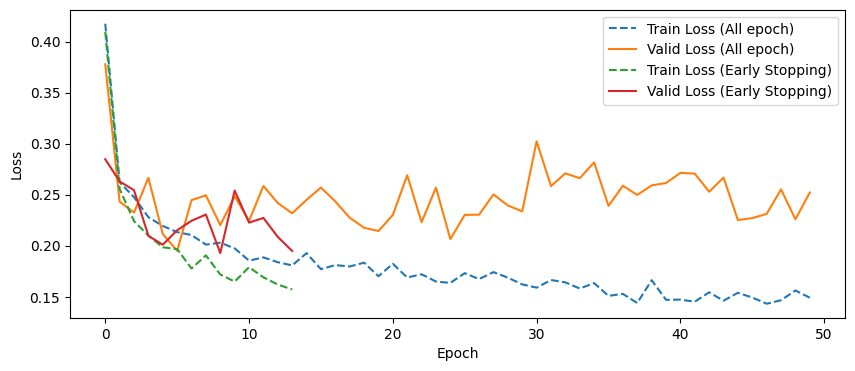

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label="Train Loss (Early Stopping)", linestyle='dashed')
plt.plot(val_es_losses, label="Valid Loss (Early Stopping)")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### (L1, )L2 적용

In [80]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
     
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Train Loss: {train_loss: .4f} Val Loss {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기 종료 epoch {epoch + 1}')
            break

    return train_losses, val_losses

In [83]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)
train_losses, val_losses = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)

train_reg(model_reg, train_loader, val_loader, optim_reg)

Epoch 1 | Train Loss:  0.4793 Val Loss 0.2362, Accuracy: 0.9297
조기 종료 epoch 1
Epoch 1 | Train Loss:  0.5087 Val Loss 0.3170, Accuracy: 0.9041
조기 종료 epoch 1


([0.5087099563380082], [0.3169670968930772])

In [84]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)


        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
    
    weight_norms = sum(torch.norm(p).item() for p in model.parameters())
    weight_norms.append(weight_norms)

    return train_losses, val_losses